# Comparison of fluxes sampled from VAE to true Distribution
# Date: 2022-03-26

In [46]:
from hydra import compose, initialize
from hydra.utils import instantiate

import torch
from torch.distributions import Normal

import bliss

In [47]:
import reconstruction
import os

os.environ["BLISS_HOME"] = "/home/dereklh/projects/bliss"

In [48]:
with initialize(config_path="./config"):
    cfg = compose(config_name="config")

In [49]:
vae = instantiate(cfg.models.galaxy_vae)

In [50]:
vae.load_state_dict(torch.load(cfg.models.decoder.galaxy_ae_ckpt))

<All keys matched successfully>

In [51]:
import numpy as np

r = np.random.RandomState(1234)
samples = r.standard_normal((1000, vae.latent_dim))
samples = torch.from_numpy(samples).to(torch.float32)

In [52]:
samples.shape

torch.Size([1000, 32])

In [200]:
with torch.no_grad():
    images = vae.get_decoder()(samples)
    fluxes = images.sum((1, 2, 3))

In [54]:
fluxes.shape

torch.Size([1000])

In [73]:
import numpy as np
import seaborn as sns
from scipy.stats import pareto
from matplotlib import pyplot as plt

We compare the fluxes of galaxies sampled from the VAE (blue) to the true pareto distribution of the DGP (black). The galaxy fluxes have a much different distribution

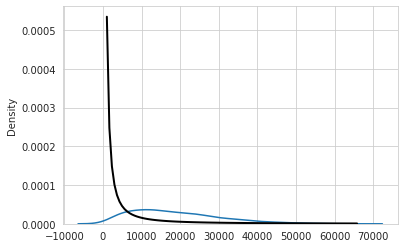

In [74]:
%matplotlib inline
sns.set_style("whitegrid")
sns.kdeplot(fluxes)
rv = pareto(0.55, 0.0, 1000.0)
x = np.linspace(rv.ppf(0.01), rv.ppf(0.90), 100)
plt.plot(x, rv.pdf(x), "k-", lw=2, label="frozen pdf")

In [77]:
sdss_galaxies = instantiate(cfg.datasets.sdss_galaxies)

torch.Size([1, 53, 53])

In [116]:
galsim_images = torch.stack([sdss_galaxies[0]["noiseless"] for _ in range(10000)])

In [117]:
galsim_fluxes = galsim_images.sum((1, 2, 3))
galsim_fluxes.shape

torch.Size([10000])

Distribution of galsim galaxy fluxes

(0.0, 100000.0)

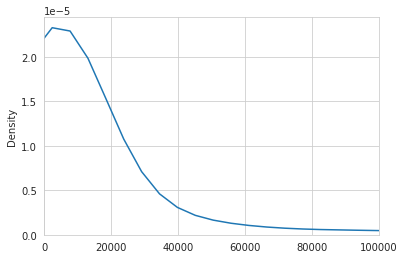

In [118]:
%matplotlib inline
sns.set_style("whitegrid")
sns.kdeplot(galsim_fluxes)
plt.xlim(0, 100_000)

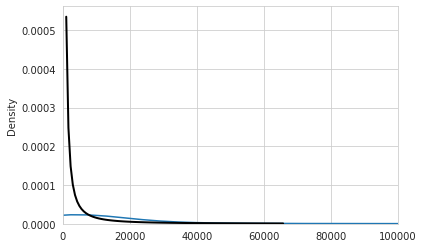

In [119]:
%matplotlib inline
sns.set_style("whitegrid")
sns.kdeplot(galsim_fluxes)
plt.xlim(0, 100_000)
rv = pareto(0.55, 0.0, 1000.0)
x = np.linspace(rv.ppf(0.01), rv.ppf(0.90), 100)
plt.plot(x, rv.pdf(x), "k-", lw=2, label="frozen pdf")

In [121]:
sdss_galaxies.flux_sample

'pareto'

In [166]:
direct_galsim_fluxes = torch.cat([sdss_galaxies._draw_pareto_flux() for _ in range(100_000)])

In [167]:
direct_galsim_fluxes.shape

torch.Size([100000])

(0.0, 100000.0)

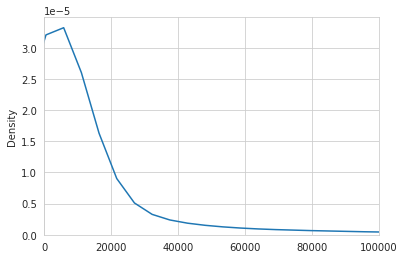

In [168]:
%matplotlib inline
sns.set_style("whitegrid")
sns.kdeplot(direct_galsim_fluxes)
plt.xlim(0, 100_000)

In [169]:
direct_galsim_fluxes.median()

tensor(3406.2236)

In [170]:
samples_pareto = rv.sample

AttributeError: 'rv_frozen' object has no attribute 'sample'

In [195]:
samples_pareto = rv.rvs(10_000)

In [196]:
samples_pareto = samples_pareto[samples_pareto <= 100_000]

<AxesSubplot:ylabel='Density'>

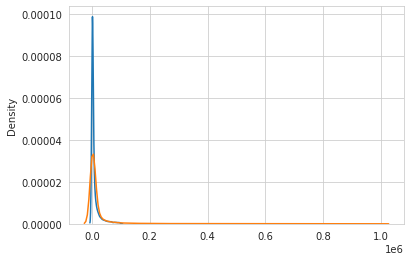

In [197]:
%matplotlib inline
sns.set_style("whitegrid")
sns.kdeplot(samples_pareto)
sns.kdeplot(direct_galsim_fluxes)
# plt.xlim(0, 1_000_000)

Samples from pareto vs VAE fluxes

<AxesSubplot:ylabel='Density'>

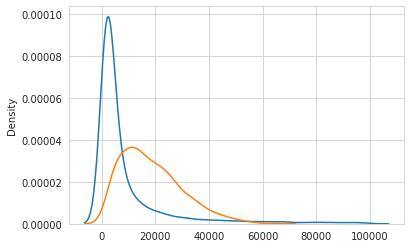

In [201]:
%matplotlib inline
sns.set_style("whitegrid")
sns.kdeplot(samples_pareto)
sns.kdeplot(fluxes)
# plt.xlim(0, 1_000_000)

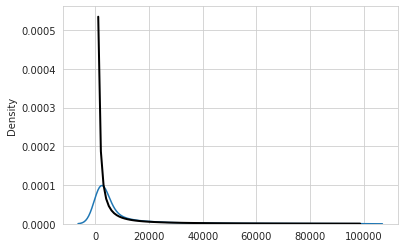

In [198]:
%matplotlib inline
sns.set_style("whitegrid")
sns.kdeplot(samples_pareto)
x = np.linspace(rv.ppf(0.01), rv.ppf(0.92), 100)
plt.plot(x, rv.pdf(x), "k-", lw=2, label="frozen pdf")

In [205]:
galsim_data = [sdss_galaxies[0] for _ in range(1000)]

In [206]:
galsim_img = torch.stack([g["images"] for g in galsim_data])
galsim_bg = torch.stack([g["background"] for g in galsim_data])

In [209]:
galsim_bg.shape

torch.Size([1000, 1, 53, 53])

In [210]:
with torch.no_grad():
    zs, divergences = vae.get_encoder()(galsim_img - galsim_bg)

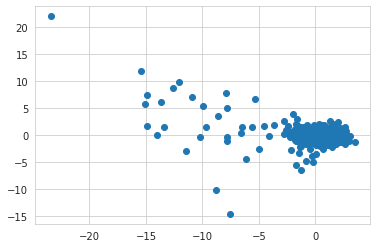

In [212]:
plt.scatter(zs[:, 0], zs[:, 1])

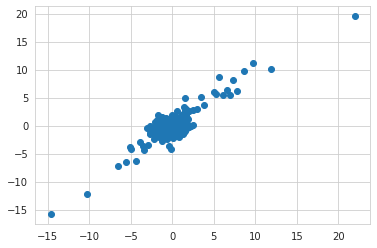

In [216]:
plt.scatter(zs[:, 1], zs[:, 2])

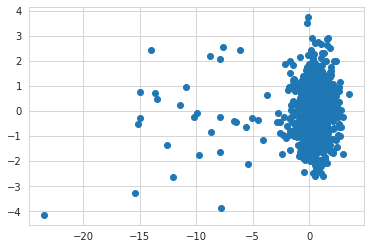

In [214]:
plt.scatter(zs[:, 0], zs[:, 10])

In [217]:
zs.shape

torch.Size([1000, 32])

In [218]:
galaxy_flow = instantiate(cfg.models.galaxy_flow)

In [219]:
galaxy_flow.load_state_dict(torch.load(cfg.paths.project + "/models/sdss_vae_flow.pt"))

<All keys matched successfully>

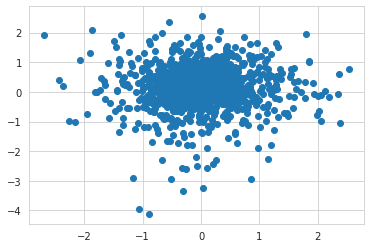

In [225]:
with torch.no_grad():
    us = galaxy_flow.flow.transform_to_noise(zs)
    plt.scatter(us[:, 0], us[:, 1])

tensor(181439.9844)


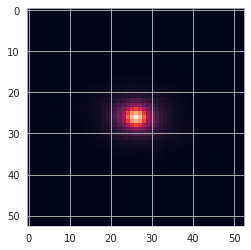

In [302]:
with torch.no_grad():
    u = galaxy_flow.sample(1)
    gal_u = vae.get_decoder()(u)
    plt.imshow(gal_u[0][0])
    print(gal_u.sum())

In [291]:
with torch.no_grad():
    u = galaxy_flow.sample(10000)
    gal_u = vae.get_decoder()(u)
    flux_u = gal_u.sum((1, 2, 3))

In [283]:
keep = ~torch.isnan(flux_u) & (flux_u <= 100_000)
flux_u = flux_u[keep]
keep.double().mean()

tensor(0.9634, dtype=torch.float64)

In [284]:
flux_u.max()

tensor(99983.3203)

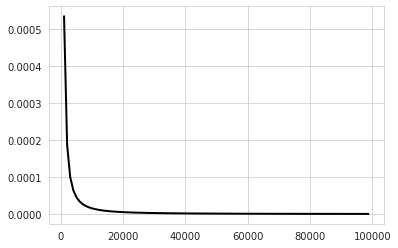

In [285]:
%matplotlib inline
sns.set_style("whitegrid")

flux_u.max()
x = np.linspace(rv.ppf(0.01), rv.ppf(0.92), 100)
plt.plot(x, rv.pdf(x), "k-", lw=2, label="frozen pdf")

<AxesSubplot:ylabel='Density'>

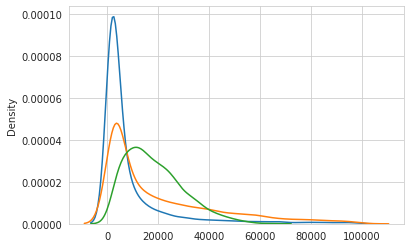

In [286]:
%matplotlib inline
sns.set_style("whitegrid")
sns.kdeplot(samples_pareto)
sns.kdeplot(flux_u)
sns.kdeplot(fluxes)
# plt.xlim(0, 1_000_000)